A notebook to fit the results of Chelsea fitting 1000 simulated DRW. These are the same as used in Celerite_fit_LC_ZI 



In [1]:

import numpy as np 
import os
import datetime
from itertools import product
from scipy.optimize import minimize

import matplotlib.pyplot as plt
from matplotlib import rcParams      
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

import celerite
import numpy as np
import matplotlib.pyplot as plt
from celerite import terms
from astropy.table import Table
from astropy.table import vstack
from astropy.table import Column





Input properties for each of the 1000 light curves  : 

  $\tau_{in} = 100 $ days
   
  $\sigma_{in} = 0.2  $ mag

  $SF_{\infty} = 0.2*\sqrt{2} = 0.2828$ mag

length = $l= 20 \tau$

dt = 5 days 

random sampling  from a uniform distribution 

yerr = 0.001  mag 

400 points 

In [2]:
# Make a dir for the results 
outDir = os.path.join(os.getcwd()[:-4],'data_products/'+'Fig_Celerite_ZI_LC_fits',
                      datetime.datetime.now().strftime('%Y-%m-%d')+ '/')
if not os.path.exists(outDir): os.system('mkdir %s' % outDir)
print('We will save this figure in  %s'%outDir)



We will save this figure in  /Users/chris/GradResearch/DRW_Celerite/data_products/Fig_Celerite_ZI_LC_fits/2017-10-27/


"I have attached the fits - the first four columns are:

1. The light curve filename
2. chi^2 of fit
3. log(tau) (in days)
4. log(sigma-hat) (in mag/sqrt(year))

The fit parameters are similar to your input, with: 

$<\tau>$ = 98.5 days 

$<\sigma> = < SF_{\infty} / \sqrt{2} > = 0.2 $ mag


The tau is more biased than sigma, since sigma-hat is well-constrained/not biased, while sigma goes as sqrt(tau).

By the way, the last column list the number of acceptable data points that went into the fit, and sometimes it is <400 because it rejects duplicate MJD values. 
"

In [3]:
# Read in Chelsea results ,  and convert to sigma, tau : 

fits = Table.read(outDir+'fits.dat', format='ascii')
tau_fit = np.power(10,fits['col3'].data)
sigma_hat = np.power(10, fits['col4'].data)
sigma_fit = sigma_hat / np.sqrt(2 / (tau/365.0))  # to convert to mag / sqrt(years)...

In [16]:
# load the results of my old fitting...
test = 'd'
simDir = '../data_products/Fig_Celerite_simulated_LC/2017-07-19/'
setup = np.load(simDir+'DRW_ZI_setup_'+test+'.npy').item()
results = np.load(simDir+'DRW_ZI_results_'+test+'.npy').item()
setup

{'dt': 0.625,
 'length': 20,
 'regular_sampling': False,
 'sigma_bounds': [0.01, 1.0],
 'sigma_in': 0.2,
 'tau_bounds': [1, 10000],
 'tau_in': 100,
 'yerr': 0.001}

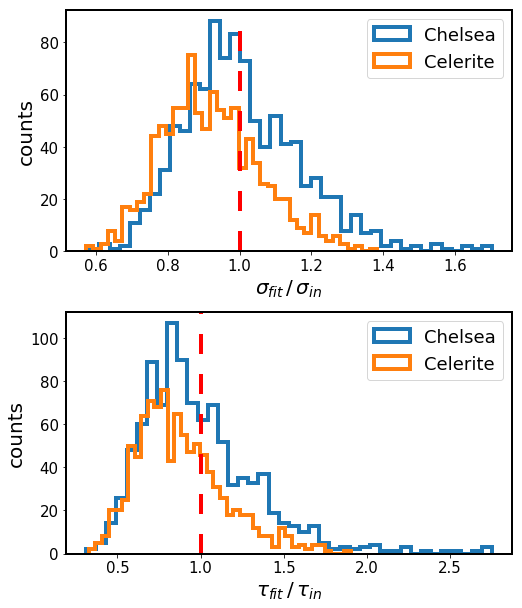

In [19]:
%matplotlib inline
# plot histograms : marginalize along either dimension ... 

fig ,ax  = plt.subplots(2,1,figsize=(8,10))

# two panels  : tau and sigma 
sigma_in = 0.2
tau_in = 100 

length = 20 
i = 0 
x0 = [0.2,0.62]

# results of Celerite with ZI light curves 
use_bounds  = True
prior = 'flat'

x =  sigma_fit / sigma_in
ax[0].hist(x, label='Chelsea' , histtype='step', lw=4, bins=40)

x =  results[use_bounds][prior]['sigma_fit'] / sigma_in
ax[0].hist(x, label = 'Celerite', histtype='step', lw=4, bins=40)
    
    
y = tau / tau_in
ax[1].hist(y,  label='Chelsea', histtype='step', lw=4, bins=40)

y = results[use_bounds][prior]['tau_fit'] / tau_in
ax[1].hist(y, label='Celerite', histtype='step', lw=4, bins=40)
    
    
ax[0].set_xlabel(r'$\sigma_{fit}\,/ \,\sigma_{in}$')
ax[1].set_xlabel(r'$\tau_{fit} \,/\, \tau_{in}$')
for i in [0,1]:
    ax[i].legend(fontsize=18)
    ax[i].axvline(1, lw=4, ls='--', c='red', dashes=(5,5))
    ax[i].set_ylabel('counts')
fig.subplots_adjust(hspace=0.25)
#fig.suptitle('N = '+str(len(t))+', length = '+str(length)+  r'$ \tau_{in}$,'+' '\
#                 +str(len(x))+' fits' + '\n' \
#                 + 'err='+str(yerr[0])+' [mag], '+b, fontsize=20)
plt.savefig(outDir + 'sigma_tau_ratios_marg.png')
# in each panel , plot histogram of both 

In [20]:
# Take exactly the same light curves , and show that Celerite fitting is 
# reproducible, largely to avoid embarassment ... 

print(setup)

# Use only 
# use_bounds  = True
# prior = 'flat'

{'sigma_in': 0.2, 'tau_in': 100, 'sigma_bounds': [0.01, 1.0], 'tau_bounds': [1, 10000], 'yerr': 0.001, 'length': 20, 'dt': 0.625, 'regular_sampling': False}


In [110]:
# Fitting  : each light curve is fit with various settings : 
# [ no_bounds,  with_bounds ] X [ flat_prior , exp_prior]

#t,y,yerr = lc['time'], lc['mag'], lc['err']

sigma_bounds = [0.001, 1.0]
tau_bounds = [1,10000]

#use_bounds = True

    
results = {}
for prior in  ['flat', 'exp', 'new']:
    results[prior] = {'sigma_fit':np.zeros(len(files), dtype=float),
                     'tau_fit':np.zeros(len(files), dtype=float)}
       
# fitting procedure : 
# initialize the kernel ... 
# it can be done once for all fittings ... 
kernel = terms.RealTerm(log_a = 2 * np.log(sigma_in) , 
                        log_c = np.log(1/tau_in))

DirIn = '../raw_data/DRWtestCeleriteZI/'
files = os.listdir(DirIn)
for i in range(len(files)) :
    # print progress... 
    if (i % 100)== 0 : 
        print(i)
        
    # read in Zeljko's light curve 
    lc = Table.read(DirIn +files[i], format='ascii', names=['time', 'mag', 'err'] )    
    t,y,yerr = lc['time'], lc['mag'], lc['err']
    
    # call the model  with a chosen kernel instance 
    gp = celerite.GP(kernel, mean=np.mean(y))
    gp.compute(t, yerr)
    
    initial_params = gp.get_parameter_vector()

    for use_bounds, prior in product([True], ['flat', 'exp', 'new']):    
        if use_bounds : # use some custom boundaries 
            logc_bounds= (np.log(1/max(tau_bounds)), np.log(1/min(tau_bounds)) )
            loga_bounds = (2*np.log(min(sigma_bounds)), 2*np.log(max(sigma_bounds)))
            bounds = [loga_bounds, logc_bounds]
        else : # use the built-in boundaries (-inf : +inf )
            bounds = gp.get_parameter_bounds()

        if prior is 'flat' : 
            def neg_log_like(params, y, gp):
                gp.set_parameter_vector(params)
                return -gp.log_likelihood(y)

        if prior is 'exp' :
            def neg_log_like(params, y, gp):
                gp.set_parameter_vector(params)
                log_a = params[0]
                log_c = params[1]
                #log_sigma = log_a / 2.0 
                #log_tau = - log_c
                return -gp.log_likelihood(y)  -0.5* (log_c - log_a - np.log(2))

        if prior is 'new' : 
            def neg_log_like(params,y,gp):
                gp.set_parameter_vector(params)
                log_a = params[0]
                log_c = params[1]
                log_sigma = log_a / 2.0 
                log_tau = - log_c
                sigma = np.exp(log_sigma)
                tau  = np.exp(log_tau)
                return -gp.log_likelihood(y) - np.log(1.0/sigma + 1.0/tau)

        # do the scipy optimize to find the maximum likelihood estimator 
        # for hyperparameters.... 
        #print('Using %s prior'%prior)
        r = minimize(neg_log_like, initial_params, 
                     method="L-BFGS-B", bounds=bounds, args=(y, gp))
        gp.set_parameter_vector(r.x)

        # retrieve the best-fit parameters 
        res = gp.get_parameter_dict()
        sigma_fit = np.exp(res['kernel:log_a']/2)
        tau_fit = 1.0 / np.exp(res['kernel:log_c'])
        results[prior]['sigma_fit'][i] = sigma_fit
        results[prior]['tau_fit'][i] = tau_fit

# Save the results ...
np.save(outDir+'ZI_fits_results_10-30-17.npy', results)        

0
100
200
300
400
500
600
700
800
900


In [111]:
results

{'exp': {'sigma_fit': array([ 0.2132833 ,  0.16735055,  0.20631499,  0.17858636,  0.16760988,
          0.18249005,  0.14561735,  0.17800919,  0.19040902,  0.20618303,
          0.17000255,  0.18176325,  0.1874108 ,  0.16270595,  0.22722719,
          0.18129965,  0.15633365,  0.17041494,  0.17057488,  0.20270985,
          0.20408278,  0.18242559,  0.17136463,  0.27229859,  0.21562246,
          0.18349832,  0.20063022,  0.17585088,  0.18979147,  0.19788663,
          0.19844616,  0.22110867,  0.17404421,  0.15549096,  0.19523857,
          0.18616091,  0.20519837,  0.13620728,  0.17372397,  0.21424178,
          0.17362775,  0.18543557,  0.19615507,  0.1843872 ,  0.18123591,
          0.14572372,  0.1859497 ,  0.22456456,  0.19842284,  0.15792091,
          0.18414312,  0.17141003,  0.16939962,  0.1897372 ,  0.20214878,
          0.202332  ,  0.20926152,  0.18138559,  0.17254908,  0.15923978,
          0.17440225,  0.23447663,  0.19086755,  0.14386479,  0.18047758,
          0.218486

### Working example : simulate observations with missing data

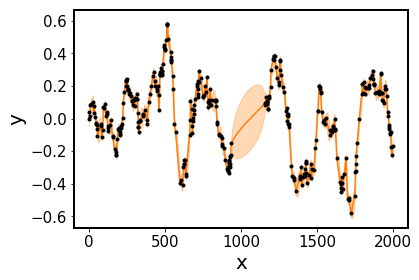

In [107]:
sigma_in = 0.2
tau_in = 100 
kernel = terms.RealTerm(log_a = 2 * np.log(sigma_in) , 
                        log_c = np.log(1/tau_in))
i=0
DirIn = '../raw_data/DRWtestCeleriteZI/'
files = os.listdir(DirIn)
lc = Table.read(DirIn +files[i], format='ascii', names=['time', 'mag', 'err'] )    

start, stop = 200, 250  
# the full observed array has 400 elements. .... 
# we remove some to simulate 'missing data window' ...

t,y,yerr = list(lc['time'][:start])+list(lc['time'][stop:]), \
    list(lc['mag'][:start])+list(lc['mag'][stop:]),\
    list(lc['err'][:start])+list(lc['err'][stop:])

    # call the model  with a chosen kernel instance 
gp = celerite.GP(kernel, mean=np.mean(y))
gp.compute(t, yerr)

initial_params = gp.get_parameter_vector()

sigma_bounds = [0.001, 1.0]
tau_bounds = [1,10000]


use_bounds = True
prior = 'new'
#for use_bounds, prior in product([True], ['flat', 'exp', 'new']):    
if use_bounds : # use some custom boundaries 
    logc_bounds= (np.log(1/max(tau_bounds)), np.log(1/min(tau_bounds)) )
    loga_bounds = (2*np.log(min(sigma_bounds)), 2*np.log(max(sigma_bounds)))
    bounds = [loga_bounds, logc_bounds]
else : # use the built-in boundaries (-inf : +inf )
    bounds = gp.get_parameter_bounds()

if prior is 'flat' : 
    def neg_log_like(params, y, gp):
        gp.set_parameter_vector(params)
        return -gp.log_likelihood(y)

if prior is 'exp' :
    def neg_log_like(params, y, gp):
        gp.set_parameter_vector(params)
        log_a = params[0]
        log_c = params[1]
        #log_sigma = log_a / 2.0 
        #log_tau = - log_c
        return -gp.log_likelihood(y)  -0.5* (log_c - log_a - np.log(2))

if prior is 'new' : 
    def neg_log_like(params,y,gp):
        gp.set_parameter_vector(params)
        log_a = params[0]
        log_c = params[1]
        log_sigma = log_a / 2.0 
        log_tau = - log_c
        sigma = np.exp(log_sigma)
        tau  = np.exp(log_tau)
        return -gp.log_likelihood(y) - np.log(1.0/sigma + 1.0/tau)

# do the scipy optimize to find the maximum likelihood estimator 
# for hyperparameters.... 
#print('Using %s prior'%prior)
r = minimize(neg_log_like, initial_params, 
             method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(r.x)

# retrieve the best-fit parameters 
res = gp.get_parameter_dict()
sigma_fit = np.exp(res['kernel:log_a']/2)
tau_fit = 1.0 / np.exp(res['kernel:log_c'])

# predict the (Gaussian) conditional (on the observed data) 
# distribution for new observations, to get the 
# estimate for standard deviation 

# where should we evaluate prediction ? 
# a) best at the same points at which we are providing hte 
# simulated dataset ... 
#  x = t

# b) at much denser sampling, so that we'll see that 
# the prediction becomes less certain when there is no
# data ... (note region around 1000...)
x = np.linspace(0, 2000, 5000) # t
pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

# plot the prediction vs the observations.... 
color = "#ff7f0e"
#plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")
plt.xlabel("x")
plt.ylabel("y")



### Plot the results .... 

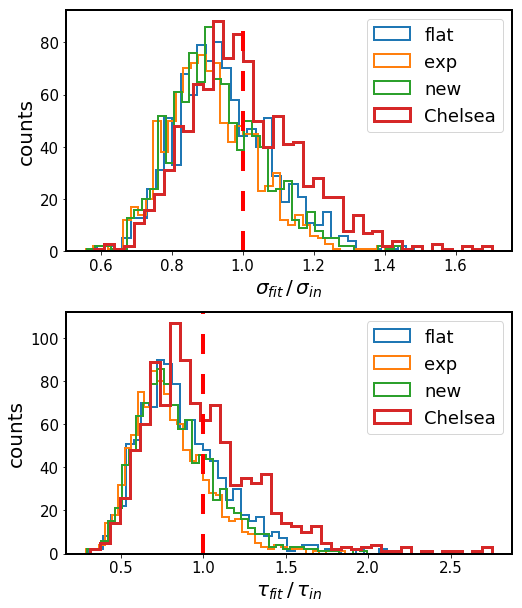

In [114]:
%matplotlib inline
# plot histograms : marginalize along either dimension ... 

fig ,ax  = plt.subplots(2,1,figsize=(8,10))

# two panels  : tau and sigma 
sigma_in = 0.2
tau_in = 100 

length = 20 
i = 0 
x0 = [0.2,0.62]


# Grab Chelsea' results ...
fits = Table.read(outDir+'fits.dat', format='ascii')
tau_fit = np.power(10,fits['col3'].data)
sigma_hat = np.power(10, fits['col4'].data)
sigma_fit = sigma_hat / np.sqrt(2 / (tau/365.0))  # to convert to mag / sqrt(years)...


# results of Celerite with ZI light curves 
use_bounds  = True
for prior in ['flat','exp','new'] : 
    x =  results[prior]['sigma_fit'] / sigma_in
    ax[0].hist(x, label = prior, histtype='step', lw=2, bins=40)

    y = results[prior]['tau_fit'] / tau_in
    ax[1].hist(y, label=prior, histtype='step', lw=2, bins=40)

# results of Chelsea 
x =  sigma_fit / sigma_in
ax[0].hist(x, label='Chelsea' , histtype='step', lw=3, bins=40)    
    
y = tau / tau_in
ax[1].hist(y,  label='Chelsea', histtype='step', lw=3, bins=40)
    
ax[0].set_xlabel(r'$\sigma_{fit}\,/ \,\sigma_{in}$')
ax[1].set_xlabel(r'$\tau_{fit} \,/\, \tau_{in}$')
for i in [0,1]:
    ax[i].legend(fontsize=18)
    ax[i].axvline(1, lw=4, ls='--', c='red', dashes=(5,5))
    ax[i].set_ylabel('counts')
fig.subplots_adjust(hspace=0.25)
#fig.suptitle('N = '+str(len(t))+', length = '+str(length)+  r'$ \tau_{in}$,'+' '\
#                 +str(len(x))+' fits' + '\n' \
#                 + 'err='+str(yerr[0])+' [mag], '+b, fontsize=20)
plt.savefig(outDir + 'sigma_tau_ratios_chelsea_celerite.png')
# in each panel , plot histogram of both 